### Implementing ReAct with LangGraph

ReAct (Reasoning + Acting) is a framework where an LLM:

* reasons step by step (e.g. decomposes questions, makes decisions)
* acts by calling tools like search, calculator or retrievers 

This makes it perfect for Agentic RAG: Think-> Retrieve -> Observe -> Reflect -> Final Answer


In [1]:
#importing libraries

import os
from dotenv import load_dotenv
load_dotenv()

from langchain.agents import create_agent
from langchain.tools import tool
from langchain_groq import ChatGroq
from langchain_community.tools import WikipediaQueryRun 
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages



d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
#base model

model = ChatGroq(model="llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001BD5E30F550>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001BD60611D90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
#creating retriever tool

url="https://lilianweng.github.io/posts/2023-06-23-agent"

loader = WebBaseLoader(web_path=url)
documents= loader.load()

chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100).split_documents(documents)

embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

vectorstore= FAISS.from_documents(documents=chunks, embedding=embeddings)

retriever= vectorstore.as_retriever()

@tool
def retriever_tool_func(query:str)-> str:
    '''This function gets the relevant documents by invoking retriever and then combines the page_content of those relevant documents'''
    relevant_docs = retriever.invoke(query)
    docs = "\n".join([doc.page_content for doc in relevant_docs])
    return docs

In [4]:
#wikipedia tool

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=500))
wikipedia

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\RAGs In Depth\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=500))

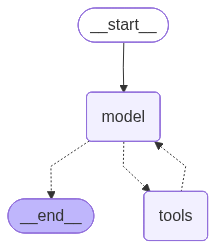

In [5]:
#creating langgraph agent
tools=[retriever_tool_func, wikipedia]

react_node = create_agent(
    model=model,
    tools=tools
)

react_node



In [6]:
#langgraph agent state

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

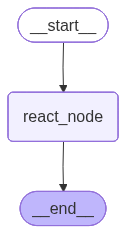

In [7]:
# building langgraph graph with nodes and edges

graph = StateGraph(AgentState)

graph.add_node("react_node", react_node)
graph.add_edge(START, "react_node")

graph_builder = graph.compile()
graph_builder


In [10]:
#running the react agent

if __name__=="__main__":
    user_query="how does self-reflection help improve autonomous agents, give few lines from wikipedia as well?"
    response = graph_builder.invoke({"messages": user_query})

    print(f"\n Final Answer: \n  {response['messages'][-1].content}")
    print("-----------------------------------------------------------------------------------")
    print(response)


 Final Answer: 
  Self-reflection can help improve autonomous agents by allowing them to:

* Identify and correct errors in their decision-making processes
* Develop a better understanding of their strengths and weaknesses
* Improve their ability to adapt to changing environments
* Enhance their ability to learn from experience and improve their performance over time

Self-reflection can also help autonomous agents to develop a sense of agency, which is the capacity to act in a given environment and to make decisions that are guided by their own goals and objectives. This can lead to more effective and efficient decision-making, as well as improved performance in complex and dynamic environments.
-----------------------------------------------------------------------------------
{'messages': [HumanMessage(content='how does self-reflection help improve autonomous agents, give few lines from wikipedia as well?', additional_kwargs={}, response_metadata={}, id='6db827ae-c62a-4b54-8029-66b